# Introduction

This notebook aims to explore various machine learning algorithms through an application to stock trading.

The below analysis will describe:
* the problem to which machine learning will be used
* exploration of the data used
* running and evaluation of the following models on training and validation data:
  - Multi-class Logistic Regression
  - kNN classification
  - Decision Tree
  - Random Forest
  - AdaBoost
  - XGBoost
  - Neural Network
* analysis of the results on test data

# Purpose

This analysis will examine historical stock price information for the S&P500 index, and using several additional features, classify whether or not the index should be bought or sold.

Additionally, this project will be used to review techniques to implement and analyze machine learning algorithms. There are countless models and paramaters to models that can be used for machine learning, this analysis will focus on a sample of common algorithms.

# Model Selection

There are several choices in the models that can be used. The data used is time series data and the goal is to classify  Buy, Sell and Hold recommendations. There are various models for this, such as those that use sliding windows and different neural network forms.

This analysis will focus on classification models, and the time series aspect will be incorporated through adding lag variables to the data. One neural network will be considered as well.

# Data Exploration

## Features

There are countless possible input features that can be added to a model. The below features were selected based on their relevance to the market as a whole. As future stock prices may be affected by recent trends, additional features have been added through simple moving average smoothing, and through adding time lags. Judgment was used in selecting the moving average timeframe and the lags.

The following features were considered:

* Date (used for indexing and splitting data)
* One Day percentage change in adjusted close prices of the S&P500
* Adjusted Close of the S&P500 with 15 day time lag
* Adjusted Close 15 day average with 15 day time lag
* Adjusted Close 50 day average with 15 day time lag
* Daily Volume
* Daily Volume 15 day average
* Daily Volume 15 day average with 15 day time lag
* Expected S&P500 EPS Growth from Analysts
* RSI technical indicator
* 10 year Treasury 15 day average
* 10 year Treasury 15 day average with 15 day time lag
* Personal consumption expenditures year over year percentage change
* Consumer price index year over year percentage change
* Real GDP year over year percentage change
* WTI Crude Oil 15 day average
* WTI Crude Oil 15 day average with 15 day time lag

Data was obtained and reviewed to ensure no missing values, and every field is numerical (no categorical variables that would require encoding).
Data in each row has been delayed appropriately if needed, so that on each row (date) the information in that row is available at time of market close. For example, real GDP is released quarterly and approximately 75 days after a quarter ends, and this delay has been adjusted for in the data.

## Output

The output variable for the data is a Buy, Hold or Sell decision classifier. There is some judgment used in determining holding period of investments, and how to determine whether an investment should be bought, sold or held. For this analysis, the classification was done by finding the change in closing price of the S&P500 after 15 trading days, and depending on it's percentage change classify as Buy, Hold or Sell.

## Exploratory Analysis

The following cells will show the first five rows of the data, and will show the scatter matrix of the data to identify any collinearity or other effects.

In [183]:
## Libraries used
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import shap

In [184]:
df = pd.read_csv("data.csv", index_col=0)
df.head()

,Adj1DayChange,AdjClosedelta15,Volume,AdjCloseMA15daydelta15,VolMA15day,VolMA14daydelta14,MA50daydelta15,ExpectedGrowth,RSI,10yrTreasuryMA15,10yrTreasurydelta15,PCEchangeyy,PCIchangeyy,GDPchangeyy,WTIOilMA15,WTIOilMA15delta15,Decision
Date,,,,,,,,,,,,,,,,,
2010-02-08,-0.008863,-93.489990,4089820000,-112.797998,4895146000,1.395593e+09,-22.366620,0.0721,35.455993,3.414667,-0.140000,1.744592,1.512335,-3.04978,69.935333,-5.284667,BUY
2010-02-09,0.013040,-67.520019,5114260000,-44.634668,4852812000,1.219364e+09,-23.907084,0.0721,41.658774,3.407333,-0.139333,1.744592,1.512335,-3.04978,69.461333,-5.779333,BUY
2010-02-10,-0.002233,-48.349975,4251450000,-48.473332,4873058667,1.084975e+09,-24.152998,0.0721,40.933474,3.406667,-0.130667,1.744592,1.512335,-3.04978,69.214000,-5.930000,BUY
2010-02-11,0.009680,-13.290039,4400870000,-50.140666,4698202667,6.036527e+08,-22.745487,0.0721,45.374472,3.413333,-0.112000,1.744592,1.512335,-3.04978,69.123333,-5.786667,BUY
2010-02-12,-0.002745,-21.270019,4160680000,-48.612671,4577684000,2.076900e+08,-21.886207,0.0721,44.356206,3.420667,-0.089333,1.744592,1.512335,-3.04978,69.188667,-5.378667,BUY


In [185]:
# Split X inputs and y output
X = df.drop(['Decision'], axis=1)
y = df['Decision']

# Time series splitting for testing and validation
tscv = TimeSeriesSplit()


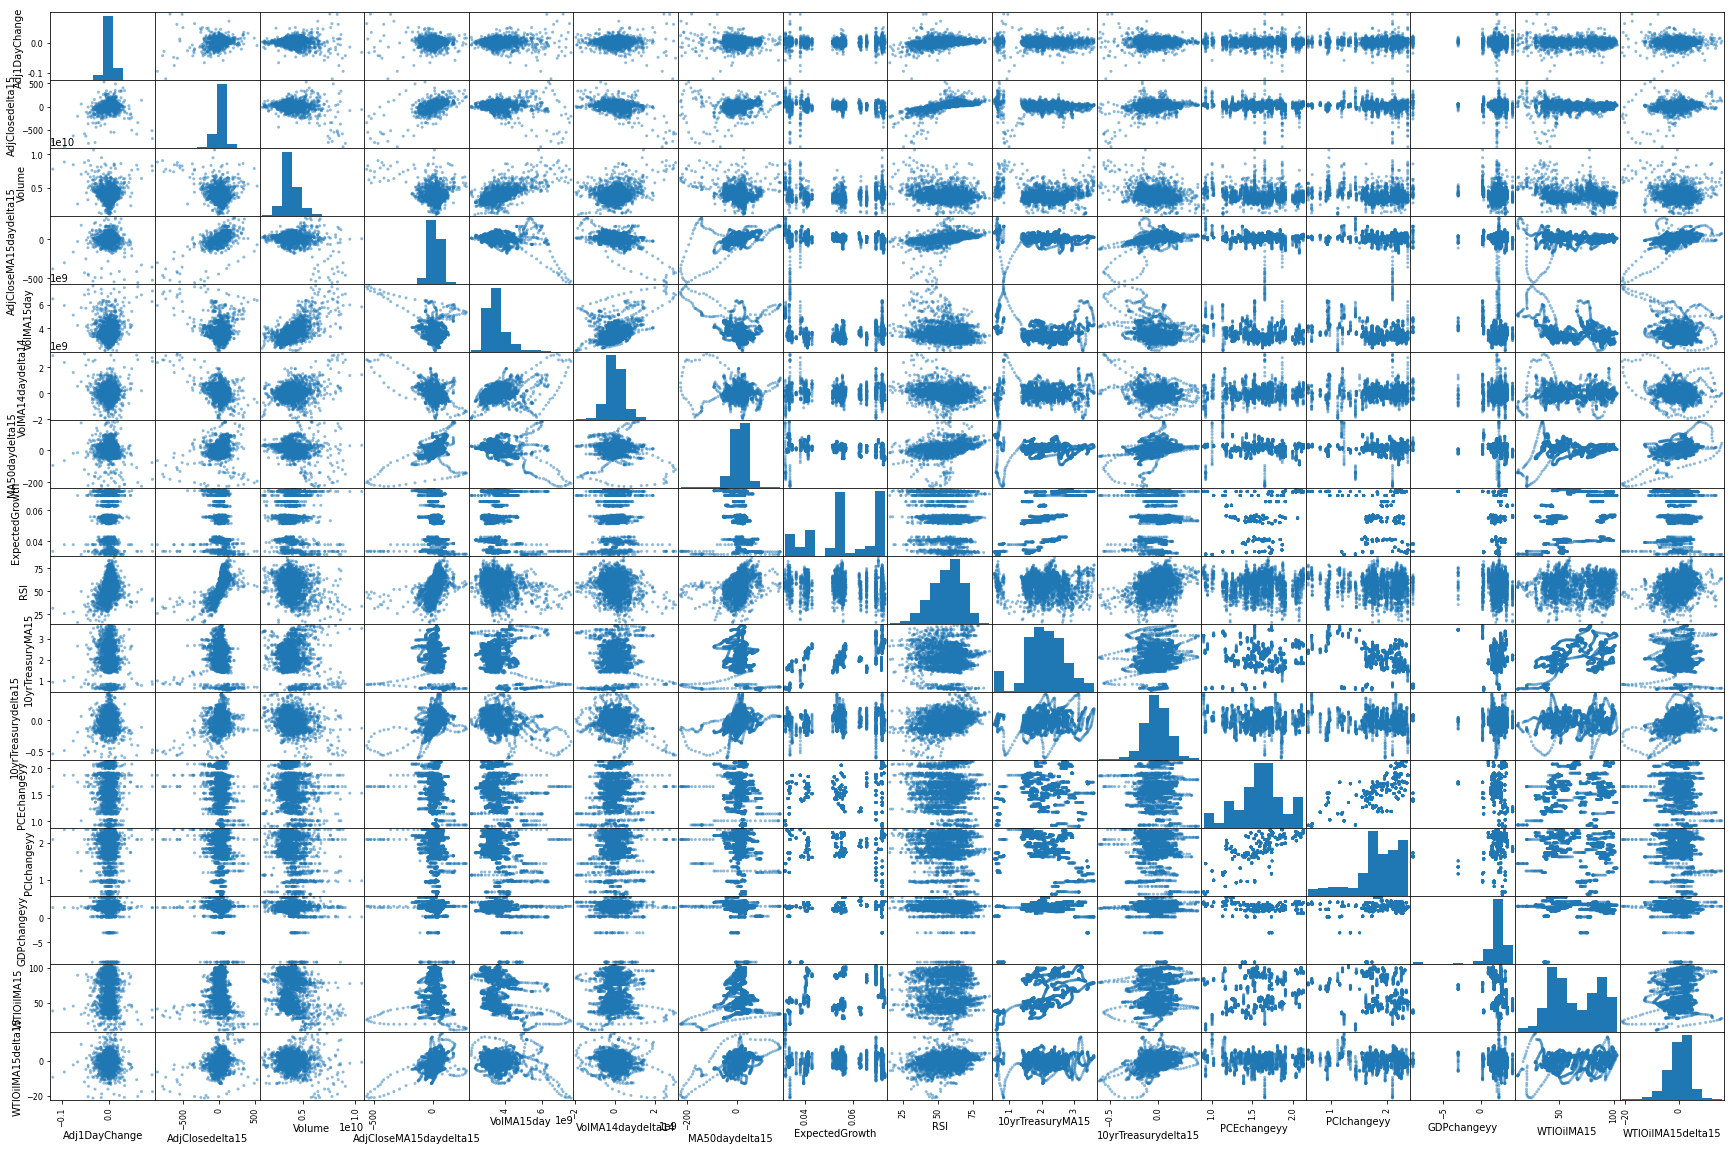

In [186]:
scatter_matrix(X, figsize=(30,20));

In [187]:
X.describe()

,Adj1DayChange,AdjClosedelta15,Volume,AdjCloseMA15daydelta15,VolMA15day,VolMA14daydelta14,MA50daydelta15,ExpectedGrowth,RSI,10yrTreasuryMA15,10yrTreasurydelta15,PCEchangeyy,PCIchangeyy,GDPchangeyy,WTIOilMA15,WTIOilMA15delta15
count,2727.000000,2727.000000,2.727000e+03,2727.000000,2.727000e+03,2.727000e+03,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000,2727.000000
mean,0.000518,12.975108,3.813867e+09,10.784546,3.560179e+09,2.053118e+06,11.883526,0.055836,56.054519,2.117851,-0.013661,1.595058,1.836071,1.934437,64.917139,-0.179385
std,0.011043,85.411993,9.359808e+08,61.171948,6.707827e+08,4.995238e+08,37.374057,0.013172,11.141778,0.627400,0.132683,0.282643,0.402975,1.781211,21.664952,4.143206
min,-0.119841,-857.110107,1.025000e+09,-557.913346,2.144223e+09,-1.957435e+09,-227.012012,0.031600,15.956872,0.534000,-0.612000,0.902110,0.602718,-9.032775,11.561333,-21.174000
25%,-0.003412,-15.310059,3.268835e+09,-10.728332,3.153825e+09,-2.784187e+08,-0.225099,0.041400,48.529190,1.722000,-0.093333,1.427604,1.687395,1.609346,46.070333,-2.540667
50%,0.000669,20.969971,3.645850e+09,17.048665,3.422655e+09,-1.519533e+07,15.346199,0.055300,57.323948,2.120667,-0.010667,1.604638,1.891531,2.183861,61.236000,0.400000
75%,0.005368,50.260131,4.163315e+09,37.167004,3.740352e+09,2.483723e+08,29.380902,0.069500,64.190578,2.531000,0.072000,1.754022,2.159820,2.672012,86.654333,2.532667
max,0.093828,524.229981,1.061781e+10,274.427360,7.559783e+09,3.025386e+09,176.947608,0.073200,86.517793,3.636000,0.430667,2.129323,2.369558,4.147747,103.149333,15.706667


In [188]:
y.value_counts()

BUY     1403
HOLD     714
SELL     610
Name: Decision, dtype: int64

# Evaluation of Selected Models

## Multi-class Logistic Regression

In [189]:
accuracies = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr = LogisticRegression(solver="lbfgs", max_iter=10000, C=0.1)
    lr.fit(X_train, y_train)
    y_pred_test = lr.predict(X_test)
    cur_accuracy = accuracy_score(y_test.to_numpy(), y_pred_test)
    accuracies.append(cur_accuracy)
    
# For illustration, the confusion matrix for the last fold in the
# time series split
confusion_matrix_logistic = pd.crosstab(  y_test.values.flatten(), 
                                      y_pred_test.flatten(), 
                                      rownames=['Actual Class'], 
                                      colnames=['Predicted Class'])
display(confusion_matrix_logistic)

print(np.mean(accuracies))

Predicted Class,BUY
Actual Class,
BUY,281
HOLD,81
SELL,92


0.5110132158590308


## kNN classification

In [190]:
mean_CV_test = {}
mean_CV_train = {}

tscv = TimeSeriesSplit()
for neighbours in [1, 15, 25]:
    cv_scores_test = []
    cv_scores_train = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        knn = KNeighborsClassifier(neighbours)
        knn.fit(X_train,y_train)
        y_pred_train = knn.predict(X_train)
        train_accuracy = accuracy_score(y_train.to_numpy(), y_pred_train)
        cv_scores_train.append(train_accuracy)
        y_pred_test = knn.predict(X_test)
        test_accuracy = accuracy_score(y_test.to_numpy(), y_pred_test)
        cv_scores_test.append(test_accuracy)
    mean_CV_train[neighbours] = np.mean(cv_scores_train)    
    mean_CV_test[neighbours] = np.mean(cv_scores_test)

best_k = sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)[0]




# For illustration, the confusion matrix for the last fold in the
# time series split
confusion_matrix_logistic = pd.crosstab(  y_test.values.flatten(), 
                                      y_pred_test.flatten(), 
                                      rownames=['Actual Class'], 
                                      colnames=['Predicted Class'])
display(confusion_matrix_logistic)

print("Training accuracy: ", mean_CV_train[best_k])
print("Testing accuracy: ", mean_CV_test[best_k])

Predicted Class,BUY,HOLD,SELL
Actual Class,,,
BUY,191,46,44
HOLD,55,8,18
SELL,66,10,16


Training accuracy:  0.569249344254547
Testing accuracy:  0.46607929515418506


## Decision tree

In [191]:
#Find optimal depth of trees
mean_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 3, 31, 4

tscv = TimeSeriesSplit()
for i in range(tree_depth_start, tree_depth_end, steps):
    cv_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = DecisionTreeClassifier(max_depth=i)
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        score = accuracy_score(y_test.to_numpy(), y_pred_test)
        cv_scores.append(score)
    mean_CV_acc[i] = np.mean(cv_scores)


best_depth = sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)[0]

# For illustration, the confusion matrix for the last fold in the
# time series split, using the best depth found
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(X_train, y_train)

confusion_matrix_logistic = pd.crosstab(y_test.values.flatten(), 
                                      y_pred_test.flatten(), 
                                      rownames=['Actual Class'], 
                                      colnames=['Predicted Class'])
display(confusion_matrix_logistic)

# Highest average accuracy of all tree depths
print(mean_CV_acc[best_depth])

Predicted Class,BUY,HOLD,SELL
Actual Class,,,
BUY,115,65,101
HOLD,34,14,33
SELL,40,9,43


0.3792951541850221


## Random forest

In [192]:
n_trees = 100

accuracies = []

model = RandomForestClassifier(n_estimators=n_trees, max_depth=best_depth+5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(accuracy)

confusion_matrix_logistic = pd.crosstab(y_test.values.flatten(), 
                                      y_pred_test.flatten(), 
                                      rownames=['Actual Class'], 
                                      colnames=['Predicted Class'])
display(confusion_matrix_logistic)
print(np.mean(accuracies))

Predicted Class,BUY,HOLD,SELL
Actual Class,,,
BUY,120,109,52
HOLD,35,20,26
SELL,35,27,30


0.41233480176211457


In [193]:

# # Create object that can calculate shap values
# explainer = shap.TreeExplainer(model)

# # Calculate Shap values
# shap_values = explainer.shap_values(X_test.iloc[0])

# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0])

In [194]:
## Random Forest has a function to show feature importance
## Commented out due to low accuracy of model

# feature_importance = model.feature_importances_
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sorted_idx = np.argsort(feature_importance)
# pos = np.arange(sorted_idx.shape[0]) + .5

# #Plot
# plt.figure(figsize=(10,12))
# plt.barh(pos, feature_importance[sorted_idx], align='center')
# plt.yticks(pos, X.columns[sorted_idx])
# plt.xlabel('Relative Importance')
# plt.title('Variable Importance')
# plt.show()

## AdaBoost

In [195]:
accuracies = []

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), 
                           n_estimators=200, 
                           learning_rate=0.05)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(accuracy)

confusion_matrix_logistic = pd.crosstab(y_test.values.flatten(), 
                                      y_pred_test.flatten(), 
                                      rownames=['Actual Class'], 
                                      colnames=['Predicted Class'])
display(confusion_matrix_logistic)
print(np.mean(accuracies))

Predicted Class,BUY,HOLD,SELL
Actual Class,,,
BUY,129,109,43
HOLD,38,18,25
SELL,38,41,13


0.39118942731277534


## XGBoost

In [196]:
# To create numerical classifiers
y2 = 0*(df['Decision']=="BUY")+1*(df['Decision']=="HOLD")+2*(df['Decision']=="SELL")

accuracies = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y2.iloc[train_index], y2.iloc[test_index]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Parameters
    param = {
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.3,               # the training step for each iteration
        'verbosity': 0,              # logging mode - quiet
        'objective': 'multi:softprob',  # error evaluation for multiclass training
        'num_class': 3}           # the number of classes that exist in this datset

    # Number of training iterations
    num_round = 200


    # Train XGBoost
    bst = xgb.train(param, 
                    dtrain, 
                    num_round, 
                    evals= [(dtrain, 'train')], 
                    early_stopping_rounds=10, # early stopping
                    verbose_eval=20)

    # Make prediction test set
    preds_test = bst.predict(dtest)
    best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

    accuracy = accuracy_score(y_test, best_preds_test)
    accuracies.append(accuracy)

confusion_matrix_logistic = pd.crosstab(y_test.values.flatten(), 
                                  best_preds_test.flatten(), 
                                  rownames=['Actual Class'], 
                                  colnames=['Predicted Class'])
display(confusion_matrix_logistic)
print(np.mean(accuracies))

[0]	train-merror:0.14442
Will train until train-merror hasn't improved in 10 rounds.
[20]	train-merror:0.00000
Stopping. Best iteration:
[17]	train-merror:0.00000

[0]	train-merror:0.22612
Will train until train-merror hasn't improved in 10 rounds.
[20]	train-merror:0.00768
[40]	train-merror:0.00000
Stopping. Best iteration:
[31]	train-merror:0.00000

[0]	train-merror:0.22271
Will train until train-merror hasn't improved in 10 rounds.
[20]	train-merror:0.01612
[40]	train-merror:0.00000
Stopping. Best iteration:
[39]	train-merror:0.00000

[0]	train-merror:0.27103
Will train until train-merror hasn't improved in 10 rounds.
[20]	train-merror:0.02584
[40]	train-merror:0.00165
Stopping. Best iteration:
[49]	train-merror:0.00000

[0]	train-merror:0.27849
Will train until train-merror hasn't improved in 10 rounds.
[20]	train-merror:0.03871
[40]	train-merror:0.00352
[60]	train-merror:0.00132
Stopping. Best iteration:
[67]	train-merror:0.00000



Predicted Class,0,1,2
Actual Class,,,
0,130,51,100
1,31,15,35
2,26,18,48


0.41541850220264315


## Neural network

In [198]:
encoder = LabelEncoder()
encoder.fit(y2)
encoded_Y = encoder.transform(y2)
dummy_y = np_utils.to_categorical(encoded_Y)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[16]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

accuracies = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = dummy_y[train_index], dummy_y[test_index]
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=256,
        epochs=10,
    )

    y_pred_test = model.predict(X_test)
    y_pred_test = np.argmax(y_pred_test, axis=1)
    y_test = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(accuracy)


confusion_matrix_logistic = pd.crosstab(y_test, 
                                      y_pred_test, 
                                      rownames=['Actual Class'], 
                                      colnames=['Predicted Class'])
display(confusion_matrix_logistic)
print(np.mean(accuracies))

Epoch 1/10
2/2 [==============================] - 0s 58ms/step - loss: 289213920.0000 - accuracy: 0.3304 - val_loss: 545486400.0000 - val_accuracy: 0.2159
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 487791968.0000 - accuracy: 0.3895 - val_loss: 320071168.0000 - val_accuracy: 0.4097
Epoch 3/10
2/2 [==============================] - 0s 3ms/step - loss: 307699392.0000 - accuracy: 0.3611 - val_loss: 239977856.0000 - val_accuracy: 0.5661
Epoch 4/10
2/2 [==============================] - 0s 8ms/step - loss: 239122224.0000 - accuracy: 0.5317 - val_loss: 42169276.0000 - val_accuracy: 0.5661
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 116517704.0000 - accuracy: 0.3873 - val_loss: 219872064.0000 - val_accuracy: 0.2181
Epoch 6/10
2/2 [==============================] - 0s 16ms/step - loss: 233620640.0000 - accuracy: 0.2779 - val_loss: 100070008.0000 - val_accuracy: 0.2181
Epoch 7/10
2/2 [==============================] - 0s 8ms/step - loss: 77202

Predicted Class,0,1,2
Actual Class,,,
0,241,21,19
1,65,7,9
2,77,2,13


0.4814977973568282


# Analysis of results

Overall, every model achieved accuracy on the testing data in the range of 35% to 48% (and the neural network can achieve under 30% accuracy depending on the random seed used). However, the models on the training data was not much better, for example, in the k-nearest neighbours classification model, the training data had an accuracy of only 56%. Thus suggesting that changes to the inputs, model or question need to be considered.

Feature importance using the feature_importance_ function and using SHAP feature importance was assessed for the random forest model. Due to low model accuracy, the results were not considered in depth and have been commented out. Features such as RSI and change in oil prices were given higher importance per the model.

## Future Considerations

There are various areas where the model can be refined, these include:
* Adding additional features, such as other lag terms or other market data information
* Adding feature modifications, such as pairwise multiplication or the log of features
* Adjusting methodology for the output 'Decision' classification
* Adjusting the accuracy function used to evaluate the models. Even though classification accuracy is not very high in the above analysis, the models can still be somewhat profitable (i.e. more profitable than just buying and holding the index, but less profitable than an optimal model that can maximize profits to buy and sell at the most opportune times)
* Varying the models and parameters used in the models

## Acknowledgement

The models used and some of the related code is based on CS 109A material: https://harvard-iacs.github.io/2019-CS109A/, as well as information from https://www.kaggle.com